## 1. Setup

In [41]:
# Check GPU
!nvidia-smi

Thu Dec  4 20:17:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   50C    P8             17W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [42]:
# Clone and setup
!git clone https://github.com/kavyavenk/multilingual-backpacks.git
%cd multilingual-backpacks

Cloning into 'multilingual-backpacks'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 408 (delta 102), reused 81 (delta 26), pack-reused 215 (from 1)
Receiving objects: 100% (408/408), 1.43 MiB | 4.37 MiB/s, done.
Resolving deltas: 100% (217/217), done.
/content/multilingual-backpacks/multilingual-backpacks/multilingual-backpacks/multilingual-backpacks


In [43]:
# Mount Drive for checkpoints (optional)
from google.colab import drive
import os

try:
    drive.mount('/content/drive')
    drive_checkpoint_dir = '/content/drive/MyDrive/multilingual-backpacks-checkpoints'
    os.makedirs(drive_checkpoint_dir, exist_ok=True)
    USE_DRIVE = True
    print("✓ Drive mounted - checkpoints will be saved")
except Exception as e:
    USE_DRIVE = False
    print("⚠️  Drive not mounted - checkpoints will only be local")
    print("   (You can download results at the end)")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Drive mounted - checkpoints will be saved


In [44]:
# Install dependencies
!pip install -q transformers datasets scipy tqdm matplotlib

In [45]:
# Verify GPU
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch: 2.9.0+cu126
CUDA: True
GPU: NVIDIA L4
Memory: 23.80 GB


## 2. Prepare Data

In [46]:
# Prepare Europarl dataset
!python data/europarl/prepare.py --language_pair en-fr --max_samples 10000

Loading Europarl dataset for en-fr...
Loaded Europarl en-fr from HuggingFace
Using subset of 10000 sentences (out of 2051014 total)
Loading tokenizer: xlm-roberta-base
Processing sentences: 100% 10000/10000 [00:00<00:00, 38556.75it/s]
Total combined texts: 20000
Tokenizing texts (this may take a few minutes)...
Tokenizing 18000 training texts...
Train batches: 100% 18/18 [00:01<00:00, 12.26it/s]
Tokenizing 2000 validation texts...
Val batches: 100% 2/2 [00:00<00:00, 13.10it/s]
Saved train data to /content/multilingual-backpacks/multilingual-backpacks/multilingual-backpacks/multilingual-backpacks/data/europarl/train.bin
Saved val data to /content/multilingual-backpacks/multilingual-backpacks/multilingual-backpacks/multilingual-backpacks/data/europarl/val.bin
Saved metadata to /content/multilingual-backpacks/multilingual-backpacks/multilingual-backpacks/multilingual-backpacks/data/europarl/meta.pkl

Vocabulary size: 250002
Data preparation complete!


In [47]:
# Verify data
import os
import pickle

with open('data/europarl/meta.pkl', 'rb') as f:
    meta = pickle.load(f)

print(f"Vocab size: {meta['vocab_size']:,}")
print(f"Languages: {meta['languages']}")

for fname in ['train.bin', 'val.bin']:
    fpath = f"data/europarl/{fname}"
    if os.path.exists(fpath):
        size = os.path.getsize(fpath) / 1e6
        print(f"✓ {fname}: {size:.2f} MB")

Vocab size: 250,002
Languages: ['en', 'fr']
✓ train.bin: 5.88 MB
✓ val.bin: 0.66 MB


In [48]:
# Restore previous checkpoint if exists
import shutil

if USE_DRIVE:
    drive_dir = '/content/drive/MyDrive/multilingual-backpacks-checkpoints/backpack'
    local_dir = 'out/backpack'

    if os.path.exists(drive_dir):
        shutil.copytree(drive_dir, local_dir, dirs_exist_ok=True)
        print(f"✓ Restored checkpoint from Drive")

        if os.path.exists(f"{local_dir}/training_log.json"):
            import json
            with open(f"{local_dir}/training_log.json") as f:
                log = json.load(f)
            print(f"  Completed {len(log['iterations'])} iterations")
            print(f"  Last loss: {log['train_loss'][-1]:.4f}")
    else:
        print("No previous checkpoint found - starting fresh")
else:
    print("Drive not available - starting fresh training")

No previous checkpoint found - starting fresh


## 3. Configure Model

In [55]:
config_content = '''"""Training config for Backpack on Europarl"""

from configurator import ModelConfig

config = ModelConfig(
    # Model architecture
    block_size=128,
    n_layer=4,
    n_head=4,
    n_embd=256,
    n_senses=4,  # 4 sense vectors per token
    dropout=0.1,
    bias=False,

    # Training
    batch_size=8,
    learning_rate=3e-4,
    max_iters=2000,
    weight_decay=1e-1,
    beta1=0.9,
    beta2=0.95,
    grad_clip=1.0,

    # Checkpoints
    eval_interval=100,
    eval_iters=50,
    log_interval=10,

    # System
    device='cuda',
    dtype='float16',
    compile=False,

    # Data
    dataset='europarl',
    tokenizer_name='xlm-roberta-base',
    languages=['en', 'fr'],
)
'''

with open('config/train_backpack.py', 'w') as f:
    f.write(config_content)

print("✓ Config created")
print("  Model: Backpack with 4 sense vectors")
print("  Embedding: 256 dim")
print("  Layers: 4")
print("  Batch size: 8")
print("  Iterations: 2000")
print("\nEstimated: ~76M params (250K vocab × 4 senses × 256 dim)")

✓ Config created
  Model: Backpack with 4 sense vectors
  Embedding: 256 dim
  Layers: 4
  Batch size: 8
  Iterations: 2000

Estimated: ~76M params (250K vocab × 4 senses × 256 dim)


## 4. Setup Auto-Backup

In [56]:
# Auto-backup to Drive every 15 minutes (if Drive available)
import time
import shutil
from threading import Thread

if USE_DRIVE:
    drive_dir = '/content/drive/MyDrive/multilingual-backpacks-checkpoints/backpack'

    def backup_loop():
        count = 0
        while True:
            time.sleep(900)  # 15 minutes
            if os.path.exists('out/backpack'):
                try:
                    shutil.copytree('out/backpack', drive_dir, dirs_exist_ok=True)
                    count += 1
                    print(f"\n[{time.strftime('%H:%M')}] ✓ Backup #{count} complete\n")
                except Exception as e:
                    print(f"\n✗ Backup failed: {e}\n")

    Thread(target=backup_loop, daemon=True).start()
    print("✓ Auto-backup started (every 15 min)")
else:
    print("⚠️  Drive not available - auto-backup disabled")
    print("   Remember to download results at the end!")

✓ Auto-backup started (every 15 min)


## 5. Train Model

In [57]:
# Clear GPU memory
import gc

torch.cuda.empty_cache()
gc.collect()

mem = torch.cuda.get_device_properties(0).total_memory / 1e9
print(f"GPU: {mem:.1f} GB available")

GPU: 23.8 GB available


In [58]:
# Train
!python train.py \
    --config train_backpack \
    --out_dir out/backpack \
    --data_dir europarl \
    --device cuda \
    --dtype float16 \
    --model_type backpack

Loading data...
Loading train.bin
Loading val.bin
Loading meta.pkl
Initializing model...
Backpack from scratch
250002
4
4
256
4
Number of parameters: 131.58M
Backpack initialized (scratch)
num decayed parameter tensors: 23, with 131,573,760 parameters
num non-decayed parameter tensors: 13, with 3,844 parameters
Starting training...
X bounds:  0 234146
Y bounds:  0 234146
X bounds:  0 238536
Y bounds:  0 238536
X bounds:  0 242799
Y bounds:  0 242799
X bounds:  0 242446
Y bounds:  0 242446
X bounds:  0 238335
Y bounds:  0 238335
X bounds:  0 242328
Y bounds:  0 242328
X bounds:  0 242333
Y bounds:  0 242333
X bounds:  0 229988
Y bounds:  0 229988
X bounds:  0 236389
Y bounds:  0 236389
X bounds:  0 227475
Y bounds:  0 227475
X bounds:  0 237332
Y bounds:  0 237332
X bounds:  0 232045
Y bounds:  0 232045
X bounds:  0 225156
Y bounds:  0 225156
X bounds:  0 230121
Y bounds:  0 230121
X bounds:  0 230331
Y bounds:  0 230331
X bounds:  0 242446
Y bounds:  0 242446
X bounds:  0 232045
Y boun

In [59]:
# Final backup (if Drive available)
if USE_DRIVE:
    drive_dir = '/content/drive/MyDrive/multilingual-backpacks-checkpoints/backpack'
    shutil.copytree('out/backpack', drive_dir, dirs_exist_ok=True)
    print("✓ Final checkpoint saved to Drive")
else:
    print("✓ Training complete - checkpoint saved locally")
    print("   Run the download cell at the end to save results")

✓ Final checkpoint saved to Drive


## 6. Visualize Training

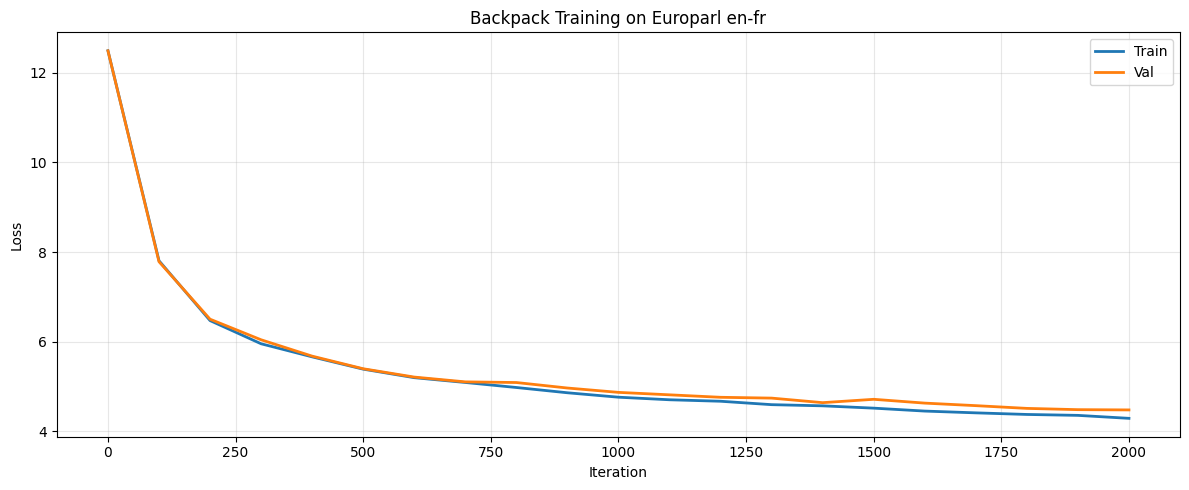


Training Summary:
  Iterations: 21
  Final train loss: 4.2930
  Final val loss: 4.4805
  Loss reduction: 8.1938


In [60]:


# Plot loss curves
import json
import matplotlib.pyplot as plt

with open('out/backpack/training_log.json') as f:
    log = json.load(f)

plt.figure(figsize=(12, 5))
plt.plot(log['iterations'], log['train_loss'], label='Train', linewidth=2)
plt.plot(log['iterations'], log['val_loss'], label='Val', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Backpack Training on Europarl en-fr')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('out/backpack/loss_curves.png', dpi=150)
plt.show()

print(f"\nTraining Summary:")
print(f"  Iterations: {len(log['iterations'])}")
print(f"  Final train loss: {log['train_loss'][-1]:.4f}")
print(f"  Final val loss: {log['val_loss'][-1]:.4f}")
print(f"  Loss reduction: {log['train_loss'][0] - log['train_loss'][-1]:.4f}")

## 7. Model Info

In [62]:
# Load model
from model import BackpackLM
import torch.serialization
from configurator import ModelConfig

# Add ModelConfig to safe globals for torch.load
torch.serialization.add_safe_globals([ModelConfig])

checkpoint = torch.load('out/backpack/ckpt.pt', map_location='cuda')
config = checkpoint['config']
model = BackpackLM(config)
model.load_state_dict(checkpoint['model'])
model.eval()

n_params = sum(p.numel() for p in model.parameters())

print("=" * 60)
print("BACKPACK MODEL")
print("=" * 60)
print(f"Embedding dim: {config.n_embd}")
print(f"Sense vectors: {config.n_senses}")
print(f"Layers: {config.n_layer}")
print(f"Heads: {config.n_head}")
print(f"Vocab: {config.vocab_size:,}")
print(f"\nTotal params: {n_params:,}")
print(f"Size: {n_params * 2 / 1e6:.1f} MB (float16)")
print("=" * 60)

Number of parameters: 131.58M
BACKPACK MODEL
Embedding dim: 256
Sense vectors: 4
Layers: 4
Heads: 4
Vocab: 250,002

Total params: 131,577,604
Size: 263.2 MB (float16)


## 8. Evaluate Sense Vectors

Analyze what each sense vector learned by looking at top-activating words

In [66]:
# Get sense embeddings
import numpy as np

# Get the base token embeddings
token_embeddings = model.token_embedding.weight

# Apply the sense layer to project base embeddings into multiple sense vectors
# model.sense_layer is a linear layer that transforms n_embd to n_senses * n_embd
projected_embeddings = model.sense_layer(token_embeddings)

# Reshape the projected embeddings to separate out the sense vectors
sense_embeddings = projected_embeddings.reshape(config.vocab_size, config.n_senses, config.n_embd).data.cpu().numpy()

print(f"Sense embeddings shape: {sense_embeddings.shape}")
print(f"Number of sense vectors per token: {sense_embeddings.shape[1]}")

Sense embeddings shape: (250002, 4, 256)
Number of sense vectors per token: 4


In [67]:
# Load tokenizer to decode tokens
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

def get_top_words_for_sense(sense_idx, k=20):
    """Get top-k words with highest activation for given sense"""
    # Get norm of each word's embedding for this sense
    sense_norms = np.linalg.norm(sense_embeddings[:, sense_idx, :], axis=1)

    # Get top-k indices
    top_indices = np.argsort(sense_norms)[-k:][::-1]

    # Decode to words
    top_words = [tokenizer.decode([idx]) for idx in top_indices]
    top_norms = sense_norms[top_indices]

    return list(zip(top_words, top_norms))

print("Top words for each sense vector:\n")
for sense_idx in range(config.n_senses):
    print(f"\n{'='*60}")
    print(f"SENSE {sense_idx + 1}")
    print(f"{'='*60}")

    top_words = get_top_words_for_sense(sense_idx, k=20)

    for i, (word, norm) in enumerate(top_words, 1):
        print(f"{i:2d}. {word:20s} (norm: {norm:.3f})")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Top words for each sense vector:


SENSE 1
 1. Monsieur             (norm: 2.725)
 2. L                    (norm: 2.379)
 3. J                    (norm: 2.163)
 4. govern               (norm: 2.157)
 5. White                (norm: 2.151)
 6. gou                  (norm: 2.149)
 7. verne                (norm: 2.070)
 8. j                    (norm: 2.038)
 9. fél                  (norm: 2.028)
10. _                    (norm: 2.020)
11. UR                   (norm: 1.964)
12. cata                 (norm: 1.948)
13. during               (norm: 1.921)
14. 2000-                (norm: 1.912)
15. LEA                  (norm: 1.877)
16. qu                   (norm: 1.861)
17. Presiden             (norm: 1.851)
18. Mada                 (norm: 1.842)
19. u                    (norm: 1.836)
20. l                    (norm: 1.803)

SENSE 2
 1. Monsieur             (norm: 2.880)
 2. L                    (norm: 2.503)
 3. govern               (norm: 2.250)
 4. White                (norm: 2.249)
 5. gou     

## 9. Cross-Lingual Word Similarity

Evaluate if similar words in English and French have similar sense vectors

In [68]:
# Test translation pairs
from scipy.spatial.distance import cosine

translation_pairs = [
    ('hello', 'bonjour'),
    ('world', 'monde'),
    ('thank', 'merci'),
    ('please', 'plaît'),
    ('good', 'bon'),
    ('bad', 'mauvais'),
    ('big', 'grand'),
    ('small', 'petit'),
    ('house', 'maison'),
    ('water', 'eau'),
]

def get_word_embedding(word):
    """Get average sense embedding for a word"""
    tokens = tokenizer.encode(word, add_special_tokens=False)
    if len(tokens) == 0:
        return None

    # Average over all senses for the first token
    token_id = tokens[0]
    return sense_embeddings[token_id].mean(axis=0)

print("Cross-lingual similarity scores:\n")
print(f"{'English':15s} {'French':15s} {'Similarity':>10s}")
print("-" * 42)

similarities = []
for en, fr in translation_pairs:
    en_emb = get_word_embedding(en)
    fr_emb = get_word_embedding(fr)

    if en_emb is not None and fr_emb is not None:
        sim = 1 - cosine(en_emb, fr_emb)
        similarities.append(sim)
        print(f"{en:15s} {fr:15s} {sim:10.4f}")

avg_sim = np.mean(similarities)
print(f"\nAverage cross-lingual similarity: {avg_sim:.4f}")
print(f"\n✓ Higher scores indicate better cross-lingual alignment")

Cross-lingual similarity scores:

English         French          Similarity
------------------------------------------
hello           bonjour            -0.0299
world           monde               0.9387
thank           merci               0.0133
please          plaît               0.2384
good            bon                -0.1340
bad             mauvais             0.2356
big             grand              -0.3598
small           petit               0.4187
house           maison              0.8052
water           eau                 0.1101

Average cross-lingual similarity: 0.2236

✓ Higher scores indicate better cross-lingual alignment


## 10. Download Results

In [69]:
# Package all results
!tar -czf backpack_results.tar.gz out/backpack/

from google.colab import files
files.download('backpack_results.tar.gz')

print("\n✓ Results downloaded")
print("\nContents:")
print("  - ckpt.pt: Model checkpoint")
print("  - training_log.json: Training metrics")
print("  - loss_curves.png: Loss visualization")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Results downloaded

Contents:
  - ckpt.pt: Model checkpoint
  - training_log.json: Training metrics
  - loss_curves.png: Loss visualization
